### Ridge versus Lasso Regularization

This is a small example that demonstrates that some of the key differences between Ridge and Lasso regularization is interpretation.  
The data set is from ISLP and is the Hitters data set, which has baseball statistics and salary for 263 players 


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('../data/Hitters.csv').dropna() #spare myself looking for the misisng data
df.head()

,Name,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       263 non-null    object 
 1   AtBat      263 non-null    int64  
 2   Hits       263 non-null    int64  
 3   HmRun      263 non-null    int64  
 4   Runs       263 non-null    int64  
 5   RBI        263 non-null    int64  
 6   Walks      263 non-null    int64  
 7   Years      263 non-null    int64  
 8   CAtBat     263 non-null    int64  
 9   CHits      263 non-null    int64  
 10  CHmRun     263 non-null    int64  
 11  CRuns      263 non-null    int64  
 12  CRBI       263 non-null    int64  
 13  CWalks     263 non-null    int64  
 14  League     263 non-null    object 
 15  Division   263 non-null    object 
 16  PutOuts    263 non-null    int64  
 17  Assists    263 non-null    int64  
 18  Errors     263 non-null    int64  
 19  Salary     263 non-null    float64
 20  NewLeague 

In [4]:

dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']]) #get some dummy variables 
X_ = df.drop(['Name','Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64') #get rid of object variables and salary
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1) #add back dummy variables 
y = df.Salary #target is salary

In [8]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

* Just plotting the single season statistics makes it obvious this data is highly colinear.  And without looking I know that as the sum, career stats are highly dependent on single season stats  

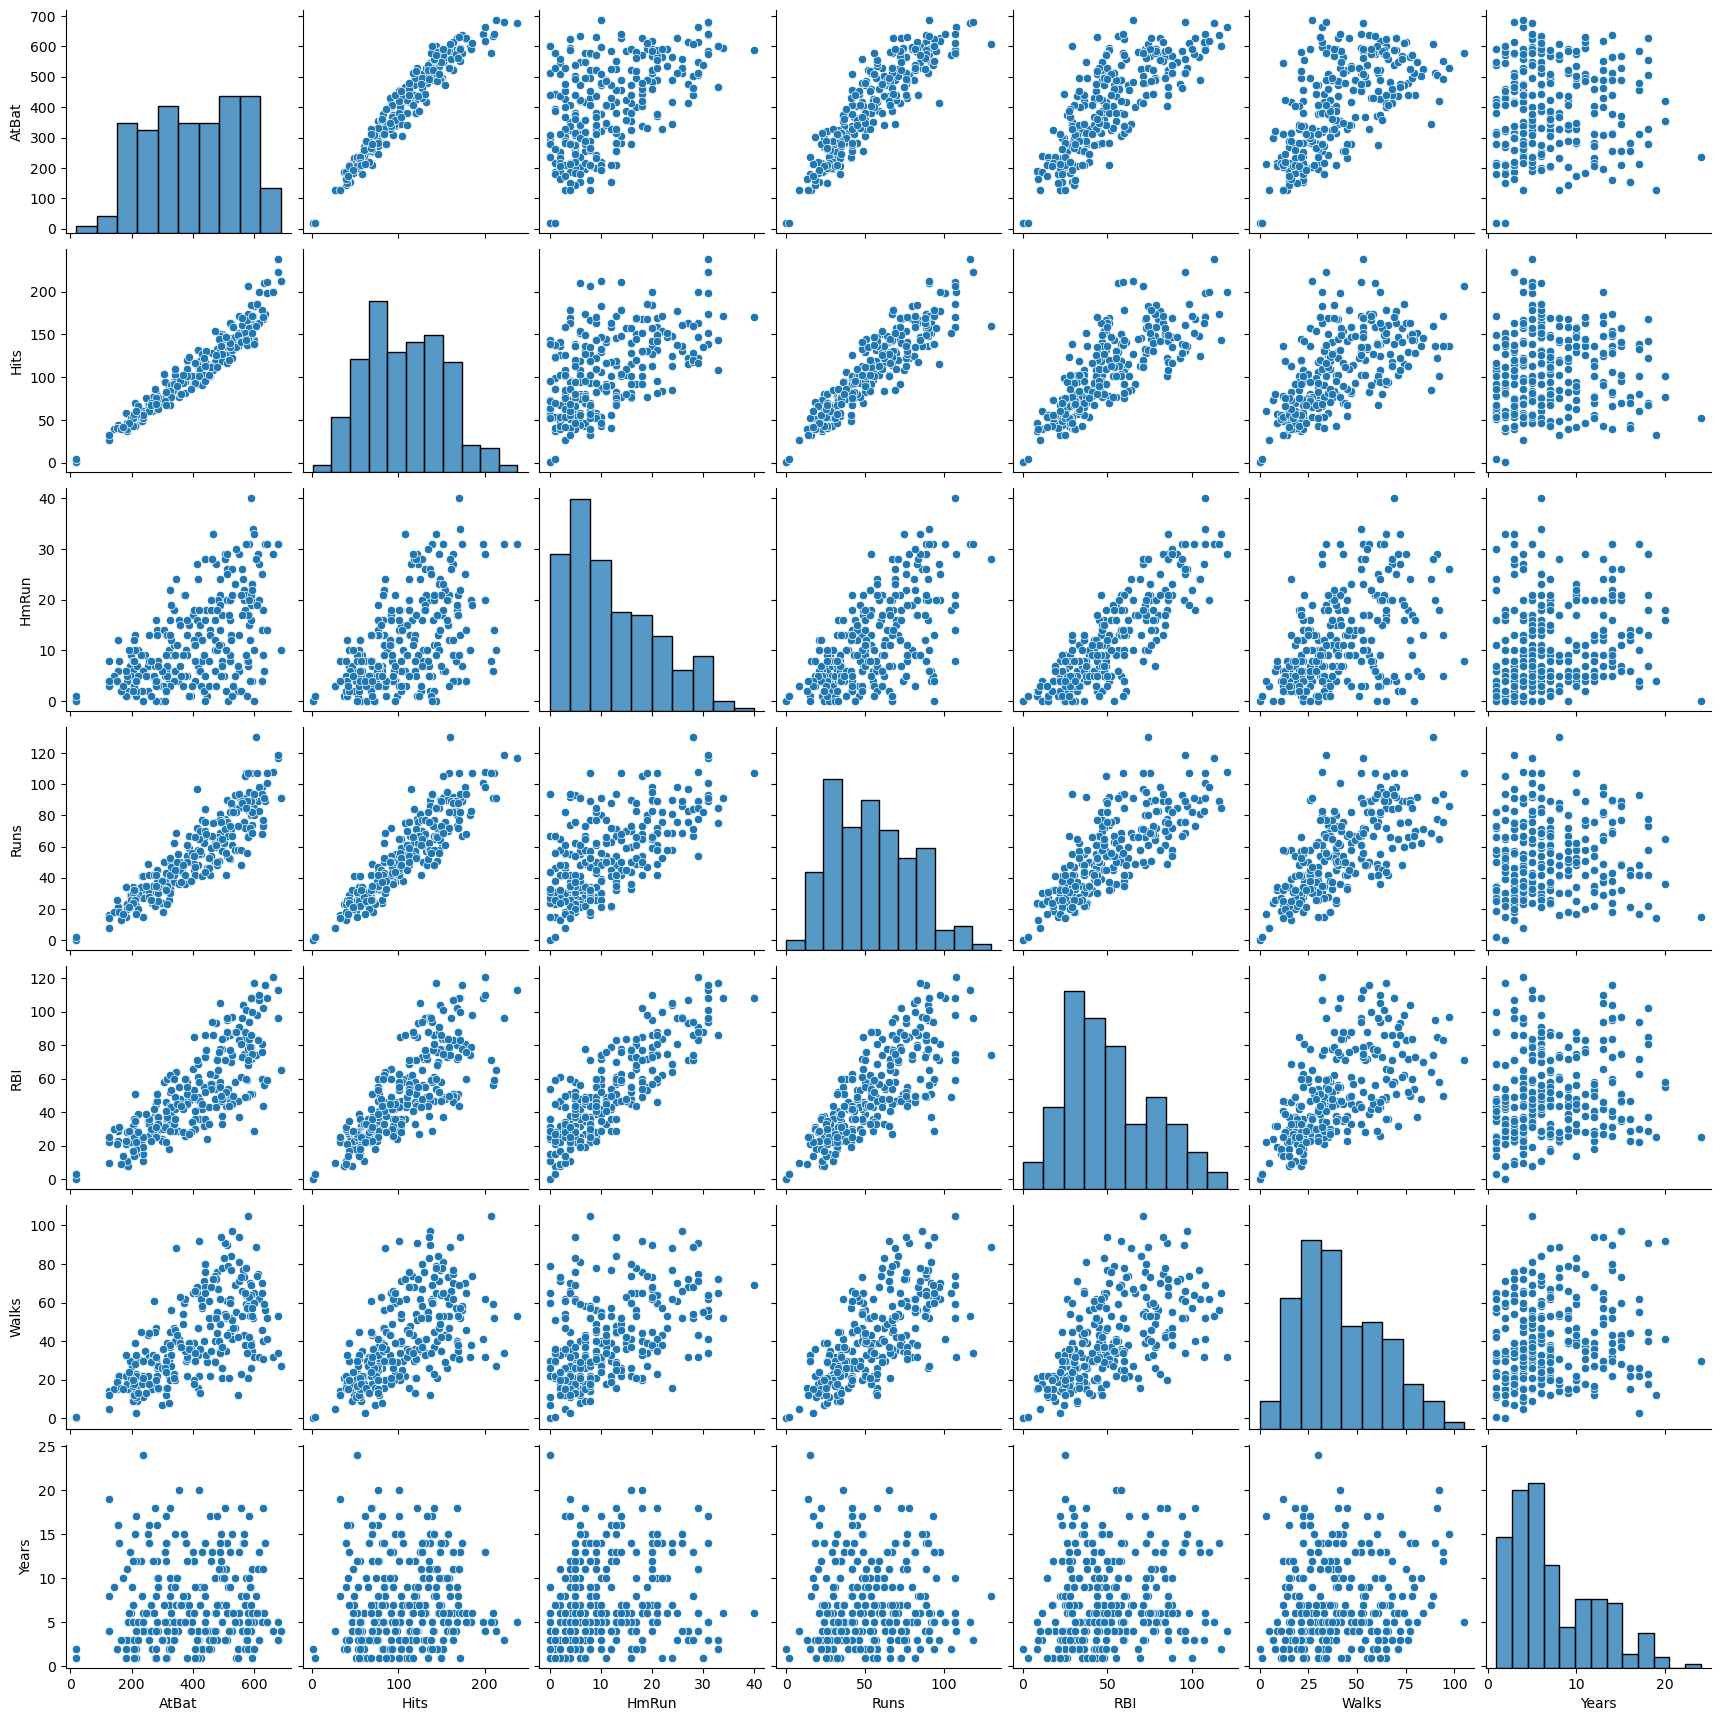

In [12]:
sns.pairplot(X.iloc[:,0:7])

### Standard Scaler 

Its a little odd to scale one-hot encoded variables.  It might make more intuitive sense to simply subtract 0.5.  In any case, you obviously cant put much meaning to the regression coefficients.  


In [13]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

### Ridge Regression
* The `Ridge()` function has an $\alpha$ argument that is $\lambda$ from the lecture notes used to tune the model.
* `Ridge()` requires a value of $\alpha$ to be speciifed. The select $\alpha$ will make use of cross-validation.  
* $\alpha$  = 0 is equivalent to the Least Squares solution, but it is not recommended to you actually set $\alpha$ = 0.  
* We expect the coefficient estimates to be much smaller, in terms of $L_2$ norm, when a large value of $\alpha$ is used,
* A very small $\alpha$ has tiny coefficients and and the model is dominated by the intercept.  

In [40]:
alphas = 10**np.linspace(10,-2,40)

* By default `RidgeCV()` performs generalized cross-validation(essentially Leave one-out CV),
* This can be changed using the argument `cv`.

In [41]:
ridgecv = RidgeCV(alphas = alphas,cv = 5) # 5-fold cross validation
ridgecv.fit(X_train, y_train) #fit model 
bestalpha = ridgecv.alpha_ #get the best value of alpha 
print(bestalpha) #


49.238826317067314


* Now we can run the model again with the best $\alpha$

In [42]:
ridge4 = Ridge(alpha = ridgecv.alpha_)
ridge4.fit(X_train,y_train)
ridge4.score(X_test, y_test)

0.4225178250163234

In [43]:
pd.Series(ridge4.coef_, index = X.columns)

AtBat         -14.215874
Hits           64.979938
HmRun         -11.821717
Runs           13.685084
RBI            37.985555
Walks          41.650542
Years          -4.158799
CAtBat         14.563845
CHits          44.123903
CHmRun         59.209231
CRuns          34.449179
CRBI           57.898335
CWalks        -15.548299
PutOuts        75.257288
Assists        -9.614693
Errors          7.072769
League_N        9.296952
Division_W    -47.195799
NewLeague_N     8.168018
dtype: float64

* Normally, at this point you are writing your **Nature** results section, and are talking about the largest coefficients you see here.  
* Ridge Regression does not perform variable selection

### The Lasso

* I would not expect Lasso to outperform Ridge, I just want a more interpretable model.  

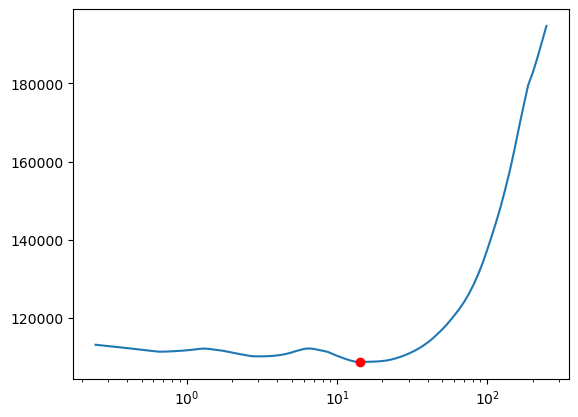

In [39]:
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100000) # the default max_iter is stupid.  
lassocv.fit(X_train, y_train)
alphas = lassocv.alphas_
thealpha = lassocv.alpha_
mse_path = lassocv.mse_path_
plt.plot(alphas,np.mean(mse_path,axis = 1))
plt.plot(thealpha,np.mean(mse_path[alphas == thealpha,:]),'ro')
plt.xscale('log')
plt.show()

* Now lets run the model with the best choice of $\alpha$

In [44]:
lasso = Lasso()
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
lasso.score(X_test,y_test)

0.4112849770718028

In [45]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat           -0.000000
Hits            90.591352
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           33.038595
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          27.981999
CRuns            0.000000
CRBI           163.191142
CWalks          -0.000000
PutOuts         83.611845
Assists         -0.000000
Errors           0.000000
League_N         0.194500
Division_W     -46.309345
NewLeague_N      2.063234
dtype: float64

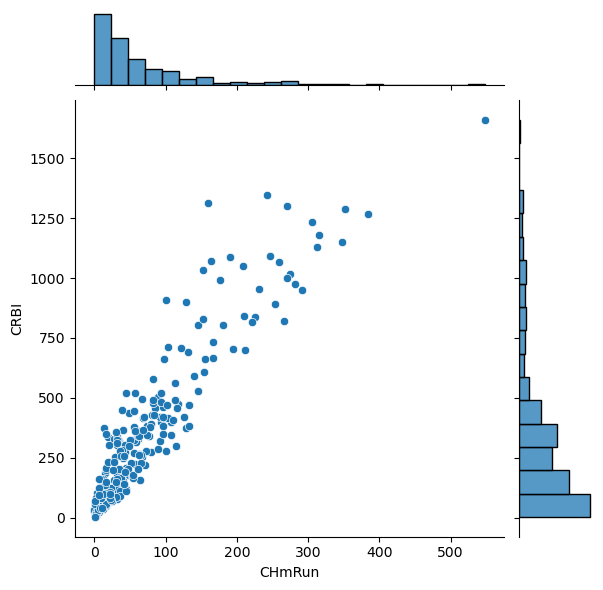

In [50]:
sns.jointplot(data=X,x="CHmRun",y="CRBI")

Unlike Ridge weights, its tricky to interpret relative lasso weights!  